In [1]:

!gdown 1KuDLpUaSe0wzDWEhgG0wKXV1_AVmzLK4
!unzip ./dataset.zip -d .

Downloading...
From: https://drive.google.com/uc?id=1KuDLpUaSe0wzDWEhgG0wKXV1_AVmzLK4
To: /kaggle/working/dataset.zip
100%|████████████████████████████████████████| 928k/928k [00:00<00:00, 17.7MB/s]
Archive:  ./dataset.zip
   creating: ./dataset/
   creating: ./dataset/private_test/
  inflating: ./dataset/private_test/private_test.zh  
   creating: ./dataset/public_test/
  inflating: ./dataset/public_test/public_test.zh  
   creating: ./dataset/train/
  inflating: ./dataset/train/train.vi  
  inflating: ./dataset/train/train.zh  


In [2]:
!pip install -qq sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 5.2 MB/s eta 0:00:00


In [3]:
import os
import random
import sentencepiece as spm # Thư viện này dùng cho quá trình tokenize
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import math
from dataclasses import dataclass
from typing import List, Tuple, Any, Dict, Optional

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torch.optim as optim
import sacrebleu

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

In [4]:
BASE_DIR = "."
TRAIN_DIR = os.path.join(BASE_DIR, "dataset", "train")
SRC_FILE = os.path.join(TRAIN_DIR, "train.zh") #SRC_FILE : Tiếng trung
TGT_FILE = os.path.join(TRAIN_DIR, "train.vi") #TGT_File : Tiếng Việt
TOKENIZER_DIR = os.path.join(BASE_DIR, "tokenizer_train32")
TOKENIZER_PREFIX = os.path.join(TOKENIZER_DIR, "spm_zh_vi_joint")
MAX_TOKENS = 32
VOCAB_SIZE = 8000
USER_SYMBOLS = ["<2zh>", "<2vi>"]

os.makedirs(TOKENIZER_DIR, exist_ok=True)

In [5]:
# ----- LOAD -----
def load_lines(path):
    with open(path, "r", encoding="utf-8") as f:
        return [l.strip() for l in f if l.strip()] # Trả về câu khi bỏ khoảng trăng thừa ở đầu và cuối chuỗi

zh_lines = load_lines(SRC_FILE)
vi_lines = load_lines(TGT_FILE)

assert len(zh_lines) == len(vi_lines), "Số câu zh và vi không khớp!"
print(f"Tổng số cặp song ngữ: {len(zh_lines):,}")

# ----- PREVIEW -----
pd.DataFrame({"zh": zh_lines[:5], "vi": vi_lines[:5]})


Tổng số cặp song ngữ: 32,061


,zh,vi
0,我 会 给 您 拿 一些 。,Tôi sẽ mang cho bạn một_ít .
1,如果 你 还 有 什么 需要 的 就 告诉 我 。,Nếu bạn cần điều gì khác hãy cho tôi biết .
2,不用 担心 那件 事 。,Đừng lo_lắng về điều đó .
3,我 要 买 它 你 不 需要 把 它 包 起来 。,Tôi sẽ mang nó và bạn không cần phải gói nó lại .
4,你 改变 吗 ？,Bạn thay_đổi không ?


ZH: mean=7.38, min=1, max=40
VI: mean=8.24, min=1, max=48


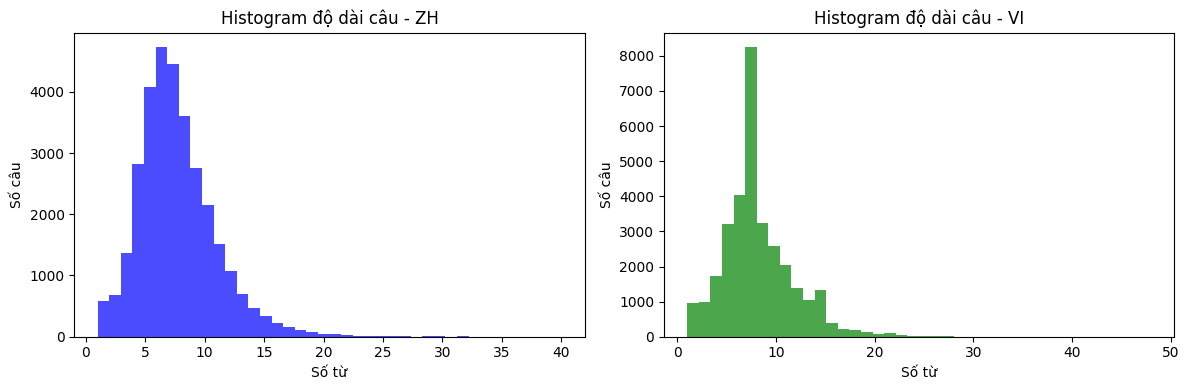

In [6]:
# ----- STATS -----
zh_len = np.array([len(s.split()) for s in zh_lines]) #Tách theo khoảng trắng
vi_len = np.array([len(s.split()) for s in vi_lines])

print(f"ZH: mean={zh_len.mean():.2f}, min={zh_len.min()}, max={zh_len.max()}")
print(f"VI: mean={vi_len.mean():.2f}, min={vi_len.min()}, max={vi_len.max()}")

# ----- PLOT -----
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.hist(zh_len, bins=40, color='blue', alpha=0.7)
plt.title("Histogram độ dài câu - ZH")
plt.xlabel("Số từ")
plt.ylabel("Số câu")

plt.subplot(1,2,2)
plt.hist(vi_len, bins=40, color='green', alpha=0.7)
plt.title("Histogram độ dài câu - VI")
plt.xlabel("Số từ")
plt.ylabel("Số câu")

plt.tight_layout()
plt.show()

In [7]:
temp_corpus = os.path.join(TOKENIZER_DIR, "temp_corpus.txt") #Tạo ra đường dẫn đến tệp tạm thời temp_corpus.txt
with open(temp_corpus, "w", encoding="utf-8") as fout:
  #Ghép từng câu tiếng trung, tiếng việt xen kẽ; mỗi câu 1 dòng
    for zh, vi in zip(zh_lines, vi_lines):
        fout.write(zh + "\n")
        fout.write(vi + "\n")
#--> temp_corpus.txt: Tập hợp các câu xen kỹ tiếng trung+ tiếng việt

spm_args = (
    f"--input={temp_corpus} ", #--input: Đường dẫn đến tệp temp_corpus
    f"--model_prefix={TOKENIZER_PREFIX} ", # --model_prefix: Tên thư mục cho file output. Ex: spm_zh_vi_joint.model và spm_zh_vi_joint.vocab
    f"--vocab_size={VOCAB_SIZE} ", #--vocab_size: Số lượng token tối đa trong từ điển
    f"--model_type=bpe ", # Thuật toán tokenize cho word
    f"--character_coverage=1.0 ", #Ép tokenize sử dụng tòa bộ ký tự trong tập train cho bộ từ điển
    "--pad_id=0 --unk_id=1 --bos_id=2 --eos_id=3 ", #Tạo ra các ký tự đặc biệt(--pad_id: Token padding);(--unk_id: CHo từ ngoài vocab);(bos_id: Bắt đầu câu);(eos_id: Kết thúc câu)
    f"--user_defined_symbols={','.join(USER_SYMBOLS)}"
 )
#Câu lệnh thực thi huấn luyện tạo ra vocab
spm.SentencePieceTrainer.Train(' '.join(spm_args))
#1.Đọc dữ liệu từ file temp_corpus.txt
#2Phân tích tần suất: Thống kê tần suất xuất hiện của các ký tự/cụm
#3.Xây dựng vocab: Áp dụng BPE để tạo vocab có kích thước VOCAB_SIZE
#4.Lưu model: Ghi ra file .model và .vocab

print(f"Tokenizer saved to {TOKENIZER_PREFIX}.model")

##TOKENIZER : Gồm
#1.{TOKENIZER_PREFIX}.model :gồm các tham số để huấn luyện tokenize và detokenize, chứa dictionary Từ token -> số
#2.{TOKENIZER_PREFIX}.vocab : col1:Toekn col2:Log probability

Tokenizer saved to ./tokenizer_train32/spm_zh_vi_joint.model


sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=./tokenizer_train32/temp_corpus.txt  --model_prefix=./tokenizer_train32/spm_zh_vi_joint  --vocab_size=8000  --model_type=bpe  --character_coverage=1.0  --pad_id=0 --unk_id=1 --bos_id=2 --eos_id=3  --user_defined_symbols=<2zh>,<2vi>
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: ./tokenizer_train32/temp_corpus.txt
  input_format: 
  model_prefix: ./tokenizer_train32/spm_zh_vi_joint
  model_type: BPE
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 1
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbo

In [8]:
#Đoạn code này thực hiện việc tải tokenizer đã huấn luyện, tải dữ liệu song ngữ (tiếng Trung và tiếng Việt),
#sau đó lọc ra các cặp câu mà cả hai câu đều có độ dài token (sau khi tokenize) không vượt quá một ngưỡng nhất định (MAX_TOK = 32).

# Load tokenizer
sp = spm.SentencePieceProcessor() #Khởi tạo bộ xử lý tokenizer
sp.Load(f"{TOKENIZER_PREFIX}.model") #Tải model đã huấn luyện trước đó
##->Sử dụng tokenizer đã học để tokenize và tính độ dài câu

# Load raw dataset
def load_lines(path):
    with open(path, "r", encoding="utf-8") as f:
        return [l.strip() for l in f if l.strip()]

zh_lines = load_lines(SRC_FILE)
vi_lines = load_lines(TGT_FILE)
assert len(zh_lines) == len(vi_lines)

MAX_TOK = 32

def tok_len(t, prefix=None):
    if prefix:
        t = f"{prefix} {t}"
    return len(sp.encode(t, out_type=int))

# Token length BEFORE filtering
zh_before = [tok_len(z, "<2vi>") for z in zh_lines] # Độ dài câu tiếng trung trc khi lọc(các câu tiếng trung đã thêm prefix)
vi_before = [tok_len(v) for v in vi_lines] #Độ dài câu tiếng Việt trước khi lọc

# Bỏ đi các câu dài quá 32 TOKEN
filtered_zh, filtered_vi = [], []
for z, v in zip(zh_lines, vi_lines):
    if tok_len(z, "<2vi>") <= MAX_TOK and tok_len(v) <= MAX_TOK:
        filtered_zh.append(z)
        filtered_vi.append(v)


ch
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=575 size=300 all=23629 active=2250 piece=áy
bpe_model_trainer.cc(159) LOG(INFO) Updating active symbols. max_freq=574 min_freq=81
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=531 size=320 all=23904 active=1439 piece=▁时候
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=498 size=340 all=24089 active=1624 piece=ực
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=478 size=360 all=24305 active=1840 piece=▁十
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=448 size=380 all=24453 active=1988 piece=▁得
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=426 size=400 all=24646 active=2181 piece=▁车
bpe_model_trainer.cc(159) LOG(INFO) Updating active symbols. max_freq=425 min_freq=69
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=403 size=420 all=24769 active=1325 piece=▁家
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=378 size=440 all=24869 active=1425 piece=em
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=362 size=460 all=24977 active=1533 piece

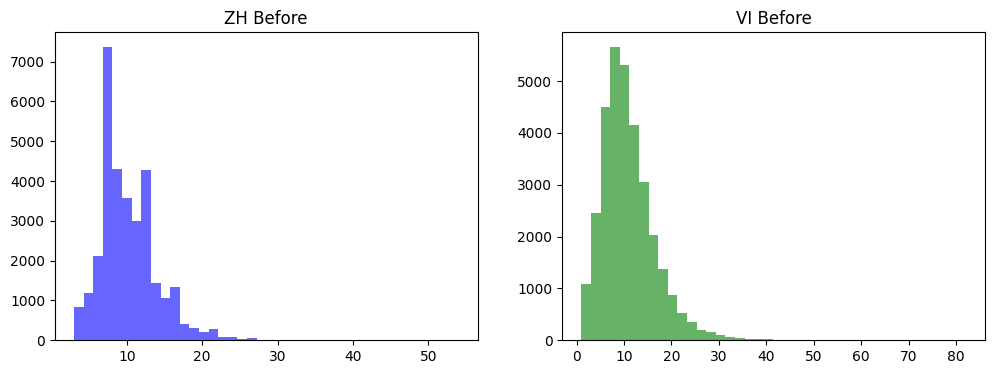

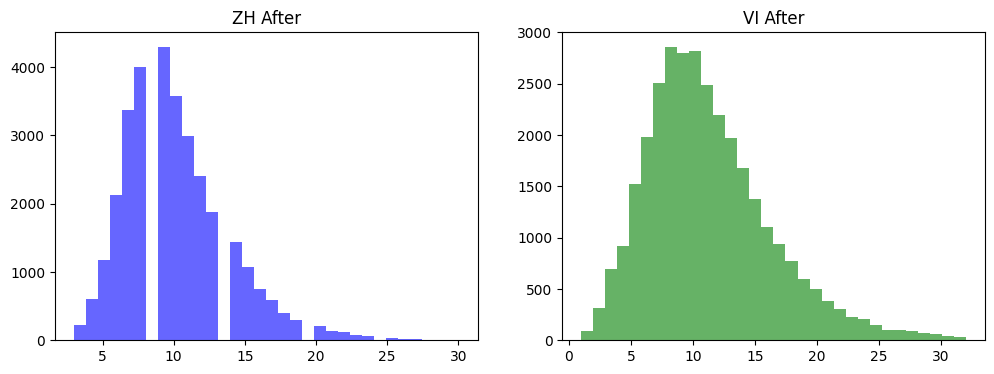

In [9]:
zh_after = np.array([tok_len(z, "<2vi>") for z in filtered_zh])
vi_after = np.array([tok_len(v) for v in filtered_vi])

plt.figure(figsize=(12,4))
plt.subplot(1,2,1); plt.hist(zh_before, bins=40, color='blue', alpha=0.6); plt.title("ZH Before")
plt.subplot(1,2,2); plt.hist(vi_before, bins=40, color='green', alpha=0.6); plt.title("VI Before")
plt.show()

plt.figure(figsize=(12,4))
plt.subplot(1,2,1); plt.hist(zh_after, bins=32, color='blue', alpha=0.6); plt.title("ZH After")
plt.subplot(1,2,2); plt.hist(vi_after, bins=32, color='green', alpha=0.6); plt.title("VI After")
plt.show()

#Trục X: mỗi cột được chia làm các khoảng có độ dài (32/40) do đó, sơ đồ histogram đặc trưng cho độ dài câu đôi khi sẽ bị trống

In [10]:
OUT_DIR = "./clean_data"
os.makedirs(OUT_DIR, exist_ok=True)

zh_out = os.path.join(OUT_DIR, f"train_maxlen{MAX_TOK}.zh")
vi_out = os.path.join(OUT_DIR, f"train_maxlen{MAX_TOK}.vi")

with open(zh_out, "w", encoding="utf-8") as fzh:
    fzh.write("\n".join(filtered_zh))

with open(vi_out, "w", encoding="utf-8") as fvi:
    fvi.write("\n".join(filtered_vi))

# ---- PRINT THÔNG TIN QUAN TRỌNG ----
total_before = len(zh_lines)
total_after = len(filtered_zh)

print(f"Saved cleaned dataset into: {OUT_DIR}")
print(f"ZH file: {zh_out}  ({total_after} lines)")
print(f"VI file: {vi_out}  ({total_after} lines)")
print(f"Filter kept: {total_after:,} / {total_before:,}")
print(f"MAX_TOKENS limit = {MAX_TOK}")


Saved cleaned dataset into: ./clean_data
ZH file: ./clean_data/train_maxlen32.zh  (31874 lines)
VI file: ./clean_data/train_maxlen32.vi  (31874 lines)
Filter kept: 31,874 / 32,061
MAX_TOKENS limit = 32


In [11]:
# --- Config ---
@dataclass
class RopeConfig:
    train_src_file: str
    train_tgt_file: str
    spm_prefix: str
    train_back_dir: str = OUT_DIR
    vocab_size: int = 8000 #Kích thước từ vựng
    d_model: int = 768 # kích thước cho vector biểu diễn
    n_heads: int = 12 # Số lượng head trong multihead attention
    n_kv_heads: int = 4 # Số lượng head cho key và value
    num_encoder_layers: int = 8 #Số lượng lớp encoder
    num_decoder_layers: int = 8 #Số lượng lớp decoder
    d_ff: int = 3072 # Kích thước cho feed-forward layer
    dropout: float = 0.01 #Tỷ lệ droupOut
    max_len: int = 32 #Độ dài tối đa của câu
    rope_base: float = 10000.0 # Tham số cơ sở cho RoPE
    pad_token: str = "<pad>"
    bos_token: str = "<s>"
    eos_token: str = "</s>"
    unk_token: str = "<unk>"
    zh_token: str = "<2zh>"
    vi_token: str = "<2vi>"
    batch_size: int = 128
    num_epochs: int = 40
    lr_base: float = 2e-4
    warmup_steps: int = 200
    weight_decay: float = 0.01
    label_smoothing: float = 0.01
    grad_clip: float = 1.0
    span_mask_prob: float = 0.01
    vi2zh_epoch_ratio: float = 0.7
    device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    num_workers: int = 8
    save_dir: str = "./checkpoints_bidirectional"
    save_every: int = 10
    seed: int = 42


config = RopeConfig(
    train_src_file=os.path.join(OUT_DIR, f"train_maxlen{MAX_TOK}.zh"),
    train_tgt_file=os.path.join(OUT_DIR, f"train_maxlen{MAX_TOK}.vi"),
    spm_prefix=TOKENIZER_PREFIX,
)

random.seed(config.seed)
torch.manual_seed(config.seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(config.seed)

os.makedirs(config.save_dir, exist_ok=True)

sp_model = spm.SentencePieceProcessor()
sp_model.Load(f"{config.spm_prefix}.model")
vocab_size = sp_model.GetPieceSize()


def read_lines(path: str) -> List[str]:
    with open(path, "r", encoding="utf-8") as f:
        return [line.strip() for line in f if line.strip()]


src_lines = read_lines(config.train_src_file)
tgt_lines = read_lines(config.train_tgt_file)
assert len(src_lines) == len(tgt_lines), "Song ngữ không cân bằng"

split_idx = int(0.95 * len(src_lines))
if split_idx % 2 != 0:
    split_idx -= 1
split_idx = max(split_idx, 0)

train_src_lines = src_lines[:split_idx] # Tập train nguồn Tiếng Trung
train_tgt_lines = tgt_lines[:split_idx] # Tập train đích Tiếng Việt

valid_src_lines, valid_tgt_lines = [], []
valid_src_all = src_lines[split_idx:]
valid_tgt_all = tgt_lines[split_idx:]
for i in range(0, len(valid_src_all), 2):
    if i < len(valid_src_all):
        valid_src_lines.append(valid_src_all[i])
        valid_tgt_lines.append(valid_tgt_all[i])

print(f"Tokenizer vocab size: {vocab_size}")
print(f"Train samples: {len(train_src_lines)} | Valid samples: {len(valid_src_lines)}")
print(f"Config device: {config.device}")

Tokenizer vocab size: 8000
Train samples: 30280 | Valid samples: 797
Config device: cpu


In [12]:
#Huấn luyện model dịch theo cả 2 chiều 1.Trung->Việt;2.Việt->Trung

class BidirectionalTranslationDataset(Dataset):
    """Sinh dữ liệu hai chiều ZH↔VI với span masking."""

    def __init__(
        self,
        src_lines: List[str],#Danh sách các câu nguồn
        tgt_lines: List[str], #Danh sách câu đích
        sp_model: spm.SentencePieceProcessor,  #Mô hình SentencePiece đã được huấn luyện, dùng để tokenize câu thành các tokenID
        config: RopeConfig,
        is_training: bool = True,
    ):
        self.src_lines = src_lines
        self.tgt_lines = tgt_lines
        self.sp = sp_model
        self.config = config
        self.is_training = is_training

        self.pad_id = sp_model.piece_to_id(config.pad_token) #padding
        self.bos_id = sp_model.piece_to_id(config.bos_token) #Token bắt đầu câu
        self.eos_id = sp_model.piece_to_id(config.eos_token) #Kết thúc câu
        self.unk_id = sp_model.piece_to_id(config.unk_token)  #Token unknown
        self.zh_id = sp_model.piece_to_id(config.zh_token) #Token chỉ định ngôn ngữ tiếng Trung(đánh dấu hướng dịch)
        self.vi_id = sp_model.piece_to_id(config.vi_token) #Token chỉ định ngôn ngữ tiếng Việt(đánh dấu hướng dịch)
        #Lấy các id tương ứng bằng piece_to_id từ mô hình SentencePiece
        self.samples = []
        if is_training: #Nếu đang ở chế độ traininng thì ta sẽ tạo dữ liệu cho 2 hướng
            for i, (src, tgt) in enumerate(zip(src_lines, tgt_lines)):
                if i % 2 == 0:
                    self.samples.append((self.add_lang_token(src, config.vi_token), tgt, "zh2vi")) # Với cặp có chỉ số chẵn, ta coi là dịch từ tiếng trung sang tiếng việt(gán nhãn zh2vi)
                else:
                    self.samples.append((self.add_lang_token(src, config.zh_token), tgt, "vi2zh")) #Với cặp có chỉ số lẻ, ta coi là dịch từ tiếng việt sang tiếng trung(gán nhãn vi2zh)
        else:
            for src, tgt in zip(src_lines, tgt_lines): #Nếu ở chế độ validation hoặc test, ta sẽ tạo dữ liệu cho 1 hướng
                self.samples.append((self.add_lang_token(src, config.vi_token), tgt, "zh2vi"))

        self.zh2vi_indices = [idx for idx, (_, _, d) in enumerate(self.samples) if d == "zh2vi"]# Danh sách chỉ số các cặp câu thuộc hướng ZH->VI
        self.vi2zh_indices = [idx for idx, (_, _, d) in enumerate(self.samples) if d == "vi2zh"]#Danh sách chỉ số các cặp câu thuộc hướng VI->ZH

    #Thêm các token ngôn ngữ vào đầu câu
    def add_lang_token(self, text: str, lang_tok: str) -> str:
        text = text.strip()
        if text.startswith("<2vi>") or text.startswith("<2zh>"):
            return text
        return f"{lang_tok} {text}"

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx: int):
        src_text, tgt_text, _ = self.samples[idx] #self.samples[idx] chứa 3 phần từ 1.câu gốc ;2. câu đích; 3. Hướng dịch
        src_ids = self.sp.encode(src_text, out_type=int)[: self.config.max_len]  #Chuyển text thành tokenIDs
        tgt_ids = [self.bos_id] + self.sp.encode(tgt_text, out_type=int) + [self.eos_id] # [token bắt đầu] +list[ID token] +[token kết thúc]
        tgt_ids = tgt_ids[: self.config.max_len]
        src_ids = self.apply_span_masking(src_ids) #Mask các từ trong câu
        return torch.tensor(src_ids, dtype=torch.long), torch.tensor(tgt_ids, dtype=torch.long)

    # Mask các từ trong câu để model có thể dự đoán các từ đã mask, giúp model hiểu sâu hơn
    def apply_span_masking(self, src_ids: List[int]) -> List[int]:  #Trả về list token IDs được mask
        if not self.is_training or random.random() > self.config.span_mask_prob: #Nếu không phải trong chế độ trainning thì giữ  nguyên
            return src_ids
        src_ids = src_ids.copy() #Lấy ra bản sao của list gốc (tránh thay đổi list gốc->Có thể dùng lại cho sample khác)
        special = {self.pad_id, self.bos_id, self.eos_id, self.zh_id, self.vi_id} #Các token đặc biệt
        maskable = [i for i, t in enumerate(src_ids) if t not in special] #maskable :Danh sách chỉ số các từ có thể mask(theo radom)
        if not maskable: #Nếu maskbale rỗng -> Trả về chuỗi nguyên bản
            return src_ids
        num_to_mask = min(random.randint(1, 2), len(maskable)) #Chỉ mask 1 hoặc 2 từ thôi
        start = random.choice(maskable)
        for i in range(start, min(start + num_to_mask, len(src_ids))):
            if i in maskable and random.random() < 0.7:
                src_ids[i] = self.unk_id
        return src_ids #Trả về list token IDs đã được mask (hoặc giữ nguyên)

#gom batch, padding các sequence về cùng độ dài và chuyển list thành tensor
def collate_fn(batch):
    src_list, tgt_list = zip(*batch)
    max_src = max(len(s) for s in src_list)
    max_tgt = max(len(t) for t in tgt_list)
    src_batch = torch.zeros(len(batch), max_src, dtype=torch.long)
    tgt_batch = torch.zeros(len(batch), max_tgt, dtype=torch.long)
    for i, (src, tgt) in enumerate(zip(src_list, tgt_list)):
        src_batch[i, : len(src)] = src
        tgt_batch[i, : len(tgt)] = tgt
    return src_batch, tgt_batch

#Hàm chọn một tập con của các chỉ số vi2zh theo từng epoch, dựa trên một tỉ lệ cho trước.
def select_vi2zh_window(indices: List[int], epoch: int, ratio: float) -> List[int]:
    if not indices or ratio <= 0:
        return []
    total = len(indices)
    window = max(1, int(math.ceil(total * min(ratio, 1.0))))
    start = ((epoch - 1) * window) % total
    end = start + window
    if end <= total:
        return indices[start:end]
    wrap = end - total
    return indices[start:] + indices[:wrap]


train_dataset = BidirectionalTranslationDataset(train_src_lines, train_tgt_lines, sp_model, config, True)
valid_dataset = BidirectionalTranslationDataset(valid_src_lines, valid_tgt_lines, sp_model, config, False)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=config.num_workers,
    pin_memory=True,
)

#Hàm tạo DataLoader cho từng epoch, chỉ chọn một tập con của dữ liệu vi2zh (theo tỉ lệ) và toàn bộ dữ liệu zh2vi.
def build_train_loader(epoch: int) -> Tuple[DataLoader, int]:
    active = list(train_dataset.zh2vi_indices)
    vi_slice = select_vi2zh_window(train_dataset.vi2zh_indices, epoch, config.vi2zh_epoch_ratio)
    active.extend(vi_slice)
    sampler = SubsetRandomSampler(active)
    loader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        sampler=sampler,
        collate_fn=collate_fn,
        num_workers=config.num_workers,
        pin_memory=True,
    )
    return loader, len(vi_slice)


print(
    f"Dataset ready | total={len(train_dataset)} | zh→vi={len(train_dataset.zh2vi_indices)} | vi→zh={len(train_dataset.vi2zh_indices)}"
)
print(f"Valid batches: {len(valid_loader)}")

Dataset ready | total=30280 | zh→vi=15140 | vi→zh=15140
Valid batches: 7


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [13]:
import torch.nn as nn
import torch.nn.functional as F


class RMSNorm(nn.Module):
    def __init__(self, d_model: int, eps: float = 1e-8):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(d_model))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        rms = torch.sqrt(torch.mean(x ** 2, dim=-1, keepdim=True) + self.eps)
        return self.weight * x / rms


class RoPE(nn.Module):
    def __init__(self, d_model: int, base: float = 10000.0):
        super().__init__()
        inv_freq = 1.0 / (base ** (torch.arange(0, d_model, 2).float() / d_model))
        self.register_buffer("inv_freq", inv_freq)
        self._cos = None
        self._sin = None
        self._seq_len_cached = 0

    def _maybe_update_cache(self, seq_len: int, device, dtype):
        if seq_len > self._seq_len_cached or self._cos is None or self._cos.device != device:
            self._seq_len_cached = seq_len
            positions = torch.arange(seq_len, device=device, dtype=dtype)
            freqs = torch.outer(positions, self.inv_freq.to(device))
            self._cos = freqs.cos()
            self._sin = freqs.sin()

    def forward(self, x: torch.Tensor, seq_len: Optional[int] = None):
        seq_len = seq_len or x.size(-2)
        self._maybe_update_cache(seq_len, x.device, x.dtype)
        return self._cos[:seq_len], self._sin[:seq_len]


def apply_rope(x: torch.Tensor, cos: torch.Tensor, sin: torch.Tensor) -> torch.Tensor:
    x1 = x[..., 0::2]
    x2 = x[..., 1::2]
    cos = cos.unsqueeze(0).unsqueeze(0)
    sin = sin.unsqueeze(0).unsqueeze(0)
    rot1 = x1 * cos - x2 * sin
    rot2 = x1 * sin + x2 * cos
    return torch.stack([rot1, rot2], dim=-1).flatten(-2)


class FFN_SwiGLU(nn.Module):
    def __init__(self, d_model: int, d_ff: int, dropout: float):
        super().__init__()
        self.d_ff = d_ff
        self.linear1 = nn.Linear(d_model, 2 * d_ff, bias=False)
        self.linear2 = nn.Linear(d_ff, d_model, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        h = self.linear1(x)
        g, v = h[..., : self.d_ff], h[..., self.d_ff :]
        s = g * torch.sigmoid(g)
        out = self.linear2(s * v)
        return self.dropout(out)

#Mỗi group 4 query_head sẽ dùng chung 1 k,v head(ví dụ: 8head, 2 kv_heads) -> 4 group, (mỗi group 4 head dùng chung 1 kv_head)
class GroupedQueryAttentionRoPE(nn.Module):
    def __init__(self, d_model: int, n_heads: int, n_kv_heads: int, dropout: float, rope_base: float):
        super().__init__()
        assert n_heads % n_kv_heads == 0
        self.n_heads = n_heads
        self.n_kv_heads = n_kv_heads
        self.n_groups = n_heads // n_kv_heads
        self.d_k = d_model // n_heads
        self.W_q = nn.Linear(d_model, n_heads * self.d_k, bias=False)
        self.W_k = nn.Linear(d_model, n_kv_heads * self.d_k, bias=False)
        self.W_v = nn.Linear(d_model, n_kv_heads * self.d_k, bias=False)
        self.W_o = nn.Linear(d_model, d_model, bias=False)
        self.dropout = nn.Dropout(dropout)
        self.scale = math.sqrt(self.d_k)
        self.rope = RoPE(self.d_k, base=rope_base)

    def forward(self, q, k, v, key_padding_mask=None, attn_mask=None):
        B, T_q = q.size(0), q.size(1)
        T_k = k.size(1)
        Q = self.W_q(q).view(B, T_q, self.n_heads, self.d_k).transpose(1, 2)
        K = self.W_k(k).view(B, T_k, self.n_kv_heads, self.d_k).transpose(1, 2)
        V = self.W_v(v).view(B, T_k, self.n_kv_heads, self.d_k).transpose(1, 2)
        cos_q, sin_q = self.rope(Q, T_q)
        cos_k, sin_k = self.rope(K, T_k)
        Q = apply_rope(Q, cos_q, sin_q)
        K = apply_rope(K, cos_k, sin_k)
        K = K.repeat_interleave(self.n_groups, dim=1) #Bản chất thì vẫn có K,V vẫn có 8 head, tuy nhiên thì có 2 cặp(mỗi cặp gồm 4 ma trận giống nhau về tham số)
        V = V.repeat_interleave(self.n_groups, dim=1)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale
        if key_padding_mask is not None:
            scores = scores.masked_fill(key_padding_mask.unsqueeze(1).unsqueeze(2), float("-inf"))
        if attn_mask is not None:
            scores = scores.masked_fill(attn_mask.unsqueeze(0).unsqueeze(0), float("-inf"))
        attn = F.softmax(scores, dim=-1)
        attn = self.dropout(attn)
        out = torch.matmul(attn, V)
        out = out.transpose(1, 2).contiguous().view(B, T_q, -1)
        return self.W_o(out)


class EncoderLayer(nn.Module):
    def __init__(self, config: RopeConfig):
        super().__init__()
        self.ln1 = RMSNorm(config.d_model)
        self.self_attn = GroupedQueryAttentionRoPE(
            config.d_model, config.n_heads, config.n_kv_heads, config.dropout, config.rope_base
        )
        self.ln2 = RMSNorm(config.d_model)
        self.ffn = FFN_SwiGLU(config.d_model, config.d_ff, config.dropout)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x, src_pad_mask=None):
        x1 = self.ln1(x)
        attn = self.self_attn(x1, x1, x1, key_padding_mask=src_pad_mask)
        x = x + self.dropout(attn)
        x2 = self.ln2(x)
        return x + self.ffn(x2)


class DecoderLayer(nn.Module):
    def __init__(self, config: RopeConfig):
        super().__init__()
        self.ln1 = RMSNorm(config.d_model)
        self.self_attn = GroupedQueryAttentionRoPE(
            config.d_model, config.n_heads, config.n_kv_heads, config.dropout, config.rope_base
        )
        self.ln2 = RMSNorm(config.d_model)
        self.cross_attn = GroupedQueryAttentionRoPE(
            config.d_model, config.n_heads, config.n_kv_heads, config.dropout, config.rope_base
        )
        self.ln3 = RMSNorm(config.d_model)
        self.ffn = FFN_SwiGLU(config.d_model, config.d_ff, config.dropout)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, y, enc_out, tgt_pad_mask=None, tgt_causal_mask=None, src_pad_mask=None):
        y1 = self.ln1(y)
        self_attn = self.self_attn(
            y1, y1, y1,
            key_padding_mask=tgt_pad_mask,
            attn_mask=tgt_causal_mask,
        )
        y = y + self.dropout(self_attn)
        y2 = self.ln2(y)
        cross_attn = self.cross_attn(y2, enc_out, enc_out, key_padding_mask=src_pad_mask)
        y = y + self.dropout(cross_attn)
        y3 = self.ln3(y)
        return y + self.ffn(y3)


class TransformerModel(nn.Module):
    def __init__(self, config: RopeConfig, vocab_size: int):
        super().__init__()
        self.config = config
        self.embedding = nn.Embedding(vocab_size, config.d_model, padding_idx=0)
        self.emb_dropout = nn.Dropout(config.dropout)
        self.encoder_layers = nn.ModuleList([EncoderLayer(config) for _ in range(config.num_encoder_layers)])
        self.encoder_final_ln = RMSNorm(config.d_model)
        self.decoder_layers = nn.ModuleList([DecoderLayer(config) for _ in range(config.num_decoder_layers)])
        self.decoder_final_ln = RMSNorm(config.d_model)
        self.output_bias = nn.Parameter(torch.zeros(vocab_size))
        self.emb_scale = math.sqrt(config.d_model)
        self._init_weights()

    def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, src_ids: torch.Tensor, tgt_ids: torch.Tensor) -> torch.Tensor:
        src_pad = (src_ids == 0)
        tgt_pad = (tgt_ids == 0)
        tgt_in = tgt_ids[:, :-1]
        tgt_pad_in = tgt_pad[:, :-1]
        T = tgt_in.size(1)
        tgt_causal = torch.triu(torch.ones(T, T, dtype=torch.bool, device=src_ids.device), diagonal=1)
        src_emb = self.emb_dropout(self.embedding(src_ids) * self.emb_scale)
        enc_out = src_emb
        for layer in self.encoder_layers:
            enc_out = layer(enc_out, src_pad)
        enc_out = self.encoder_final_ln(enc_out)
        tgt_emb = self.emb_dropout(self.embedding(tgt_in) * self.emb_scale)
        dec_out = tgt_emb
        for layer in self.decoder_layers:
            dec_out = layer(dec_out, enc_out, tgt_pad_in, tgt_causal, src_pad)
        dec_out = self.decoder_final_ln(dec_out)
        return F.linear(dec_out, self.embedding.weight, self.output_bias)

In [14]:
#loss function
class LabelSmoothedCrossEntropyLoss(nn.Module):
    def __init__(self, smoothing: float = 0.1, ignore_index: int = 0): #ignore_index : Bỏ qua các token <padding> và padding_ID thương có ID =0
        super().__init__()
        self.smoothing = smoothing
        self.ignore_index = ignore_index
    #logits[batch, seq_len, vocab_size] (chưa qua softmax)  ; target [batch,seq_len] thể hiện nhãn thật của các từ
    def forward(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        vocab_size = logits.size(-1)
        log_probs = F.log_softmax(logits, dim=-1) #
        mask = targets != self.ignore_index #Vd: targets=[1,2,0,3,0] thì mask=[True,True,False,True,Fasle]
        with torch.no_grad():
            true_dist = torch.full_like(
                log_probs, self.smoothing / (vocab_size - 1))  #torch.full_like(log_probs, value): Tạo tensor cùng shape với log_probs, fill với value
            true_dist.scatter_(1, targets.unsqueeze(1), 1.0 - self.smoothing)
            true_dist[targets == self.ignore_index] = 0.0 #Các chỉ số trong targets=0 thì
        loss = -(true_dist * log_probs).sum(dim=-1) #Loss cho nhiều token.
        loss = loss.masked_fill(~mask, 0.0)# Các token là token padding sẽ có index bằng 0
        return loss.sum() / mask.sum().clamp(min=1) #Tổng loss của non-padding token / tổng số lượng non-padding token
# Ban đầu: true_dist (batch=1, seq_len=3, vocab=5)
# Tất cả = 0.025
#[
  #[[0.025, 0.025, 0.025, 0.025, 0.025],  # Token 0
   #[0.025, 0.025, 0.025, 0.025, 0.025],  # Token 1
   #[0.025, 0.025, 0.025, 0.025, 0.025]]  # Token 2
#]

# Sau scatter với targets=[[1, 2, 3]] và value=0.9:
#[
  #[[0.025, 0.900, 0.025, 0.025, 0.025],  # Token 0: class 1 = 0.9
  # [0.025, 0.025, 0.900, 0.025, 0.025],  # Token 1: class 2 = 0.9
   #[0.025, 0.025, 0.025, 0.900, 0.025]]  # Token 2: class 3 = 0.9
#]


#learning rate scheduler
#Chiến thuật; chia làm 2 giai đoạn Giai đoạn 1:Tăng dần theo từng step , Giai đoạn 2: Giảm dần theo từng step
class WarmupInverseSqrtScheduler:
    def __init__(self, optimizer, warmup_steps: int, lr_base: float):
        self.optimizer = optimizer
        self.warmup_steps = warmup_steps
        self.lr_base = lr_base
        self.step_num = 0

    def step(self):
        self.step_num += 1
        if self.step_num <= self.warmup_steps:
            lr = self.lr_base * self.step_num / self.warmup_steps
        else:
            lr = self.lr_base * math.sqrt(self.warmup_steps) / math.sqrt(self.step_num)
        for group in self.optimizer.param_groups:
            group["lr"] = lr

    def get_lr(self):
        return self.optimizer.param_groups[0]["lr"]


def train_epoch(model, dataloader, criterion, optimizer, scheduler, config: RopeConfig, epoch: int) -> float:
    model.train()
    total_loss = 0.0
    pbar = tqdm(dataloader, desc=f"Epoch {epoch}")
    for src_batch, tgt_batch in pbar:
        src_batch = src_batch.to(config.device)
        tgt_batch = tgt_batch.to(config.device)
        logits = model(src_batch, tgt_batch)
        targets = tgt_batch[:, 1:]
        loss = criterion(logits.reshape(-1, logits.size(-1)), targets.reshape(-1))
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), config.grad_clip)
        optimizer.step() #Cập nhật tham số w
        scheduler.step() # Cặp nhật learning rate
        total_loss += loss.item()
        pbar.set_postfix(loss=f"{loss.item():.4f}", lr=f"{scheduler.get_lr():.6f}")
    return total_loss / len(dataloader)


@dataclass
class BeamSearchHypothesis:
    tokens: list
    log_prob: float

#Dịch câu trong quá trình validation
@torch.no_grad()
def greedy_decode(
    model: TransformerModel,
    src_ids: torch.Tensor, #Token id của từ trong câu gốc
    sp_model: spm.SentencePieceProcessor, #tokenier
    config: RopeConfig,
    max_len: int = 32, #Độ dài tối đa câu đc gen ra
):
    """Fast greedy decoding for validation BLEU calculation"""
    model.eval() #Tắt dropout
    batch_size = src_ids.size(0)
    device = src_ids.device
    bos = sp_model.piece_to_id(config.bos_token)
    eos = sp_model.piece_to_id(config.eos_token)
    pad = sp_model.piece_to_id(config.pad_token)

    # Encode source
    src_pad_mask = (src_ids == pad) #Tạo padding mask cho câu nguồn
    src_emb = model.embedding(src_ids) * model.emb_scale
    src_input = model.emb_dropout(src_emb)
    enc_out = src_input
    for layer in model.encoder_layers:
        enc_out = layer(enc_out, src_pad_mask)
    enc_out = model.encoder_final_ln(enc_out)

    # Initialize decoder input
    tgt_ids = torch.full((batch_size, 1), bos, dtype=torch.long, device=device) #Tạo tensor chỉ chứa token bos(bắt đầu câu)

    for _ in range(max_len):
        tgt_pad = (tgt_ids == pad) #Tạo padding mask cho câu đích
        tgt_len = tgt_ids.size(1)
        tgt_causal = torch.triu(torch.ones(tgt_len, tgt_len, dtype=torch.bool, device=device), diagonal=1) #Để các token phía trước không thấy các token phía sau trong quá trình tính attention score

        tgt_emb = model.embedding(tgt_ids) * model.emb_scale #
        tgt_input = model.emb_dropout(tgt_emb)
        dec_out = tgt_input
        for layer in model.decoder_layers:
            dec_out = layer(dec_out, enc_out, tgt_pad, tgt_causal, src_pad_mask)
        dec_out = model.decoder_final_ln(dec_out)

        logits = F.linear(dec_out, model.embedding.weight, model.output_bias)
        next_tokens = torch.argmax(logits[:, -1, :], dim=-1, keepdim=True)
        tgt_ids = torch.cat([tgt_ids, next_tokens], dim=1)

        # Stop if all sequences have EOS
        if (next_tokens.squeeze(-1) == eos).all():
            break

    # Decode to text
    decoded = []
    for seq in tgt_ids:
        tokens = seq[1:].cpu().tolist()  # Skip BOS
        if eos in tokens:
            tokens = tokens[:tokens.index(eos)]
        decoded.append(sp_model.decode(tokens))

    return decoded

#Chưa dùng đển. Thử test xem sao
@torch.no_grad()
def beam_search_decode(
    model: TransformerModel,
    src_ids: torch.Tensor,
    sp_model: spm.SentencePieceProcessor,
    config: RopeConfig,
    beam_size: int = 3,
    top_k: int = 3,
    max_len: int = 32,
    length_penalty: float = 0.6,
):
    model.eval()
    batch_size = src_ids.size(0)
    device = src_ids.device
    bos = sp_model.piece_to_id(config.bos_token)
    eos = sp_model.piece_to_id(config.eos_token)
    pad = sp_model.piece_to_id(config.pad_token)
    src_pad_mask = (src_ids == pad)
    src_emb = model.embedding(src_ids) * model.emb_scale
    src_input = model.emb_dropout(src_emb)
    enc_out = src_input
    for layer in model.encoder_layers:
        enc_out = layer(enc_out, src_pad_mask)
    enc_out = model.encoder_final_ln(enc_out)
    decoded = []
    for b in range(batch_size):
        beams = [BeamSearchHypothesis(tokens=[bos], log_prob=0.0)]
        finished = []
        single_enc = enc_out[b : b + 1]
        single_mask = src_pad_mask[b : b + 1]
        for _ in range(max_len):
            new_beams = []
            for beam in beams:
                if beam.tokens[-1] == eos:
                    finished.append(beam)
                    continue
                tgt_ids = torch.tensor(beam.tokens, dtype=torch.long, device=device).unsqueeze(0)
                tgt_pad = (tgt_ids == pad)
                tgt_len = tgt_ids.size(1)
                tgt_causal = torch.triu(torch.ones(tgt_len, tgt_len, dtype=torch.bool, device=device), diagonal=1)
                tgt_emb = model.embedding(tgt_ids) * model.emb_scale
                tgt_input = model.emb_dropout(tgt_emb)
                dec_out = tgt_input
                for layer in model.decoder_layers:
                    dec_out = layer(dec_out, single_enc, tgt_pad, tgt_causal, single_mask)
                dec_out = model.decoder_final_ln(dec_out)
                logits = F.linear(dec_out, model.embedding.weight, model.output_bias)
                log_probs = F.log_softmax(logits[:, -1, :], dim=-1)
                if top_k and top_k > 0:
                    top_val, top_idx = torch.topk(log_probs, min(top_k, log_probs.size(-1)))
                    mask = torch.full_like(log_probs, float("-inf"))
                    mask.scatter_(1, top_idx, top_val)
                    log_probs = mask
                top_vals, top_idx = torch.topk(log_probs.squeeze(0), beam_size)
                for val, idx in zip(top_vals.tolist(), top_idx.tolist()):
                    new_beams.append(BeamSearchHypothesis(tokens=beam.tokens + [idx], log_prob=beam.log_prob + val))
            beams = sorted(new_beams, key=lambda h: h.log_prob, reverse=True)[:beam_size]
            if not beams:
                break
        finished.extend(beams)
        best = max(finished, key=lambda h: h.log_prob / (len(h.tokens) ** length_penalty))
        tokens = best.tokens[1:]
        if eos in tokens:
            tokens = tokens[: tokens.index(eos)]
        decoded.append(sp_model.decode(tokens))
    return decoded


@torch.no_grad()
def evaluate(model, dataloader, criterion, sp_model, config: RopeConfig, calculate_bleu: bool = True, max_bleu_samples: int = 500):
    """
    Fast evaluation with optional BLEU calculation
    Args:
        calculate_bleu: Whether to calculate BLEU score (slower)
        max_bleu_samples: Maximum number of samples for BLEU calculation
    """
    model.eval()
    total_loss = 0.0
    all_predictions, all_references = [], []

    bleu_count = 0
    for i, (src_batch, tgt_batch) in enumerate(tqdm(dataloader, desc="Evaluating", leave=False)):
        src_batch = src_batch.to(config.device)
        tgt_batch = tgt_batch.to(config.device)

        # Always calculate loss
        logits = model(src_batch, tgt_batch)
        targets = tgt_batch[:, 1:]
        loss = criterion(logits.reshape(-1, logits.size(-1)), targets.reshape(-1))
        total_loss += loss.item()

        # Only calculate BLEU on subset for speed
        if calculate_bleu and bleu_count < max_bleu_samples:
            # Use greedy decoding instead of beam search for speed
            preds = greedy_decode(model, src_batch, sp_model, config, max_len=config.max_len)

            eos = sp_model.piece_to_id(config.eos_token)
            for tgt_seq in tgt_batch:
                ref = tgt_seq[1:].cpu().tolist()
                if eos in ref:
                    ref = ref[: ref.index(eos)]
                all_references.append(sp_model.decode(ref))

            all_predictions.extend(preds)
            bleu_count += len(preds)

            # Stop if we have enough samples for BLEU
            if bleu_count >= max_bleu_samples:
                break

    avg_loss = total_loss / len(dataloader)
    bleu_score = 0.0

    if calculate_bleu and sacrebleu is not None and all_predictions:
        try:
            bleu = sacrebleu.corpus_bleu(all_predictions, [all_references], force=True)
            bleu_score = bleu.score
        except Exception as err:
            print(f"BLEU calculation failed: {err}")

    return avg_loss, bleu_score

In [15]:
def package_tokenizer(prefix: str) -> Dict[str, Any]:
    model_path = f"{prefix}.model"
    vocab_path = f"{prefix}.vocab"
    if not (os.path.isfile(model_path) and os.path.isfile(vocab_path)):
        raise FileNotFoundError(f"Missing tokenizer files at {prefix}.[model|vocab]")
    with open(model_path, "rb") as f:
        model_bytes = f.read()
    with open(vocab_path, "rb") as f:
        vocab_bytes = f.read()
    return {"prefix": prefix, "model_bytes": model_bytes, "vocab_bytes": vocab_bytes}


model = TransformerModel(config, vocab_size).to(config.device)
criterion = LabelSmoothedCrossEntropyLoss(config.label_smoothing, ignore_index=0)
optimizer = optim.AdamW(
    model.parameters(),
    lr=config.lr_base,
    betas=(0.9, 0.98),
    eps=1e-9,
    weight_decay=config.weight_decay,
)
scheduler = WarmupInverseSqrtScheduler(optimizer, config.warmup_steps, config.lr_base)
tokenizer_payload = package_tokenizer(config.spm_prefix)

print(f"Model params: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print(f"Saving checkpoints to: {config.save_dir}")

best_val_loss = float("inf")
best_val_bleu = 0.0

for epoch in range(1, config.num_epochs + 1):
    train_loader, vi_slice_len = build_train_loader(epoch)
    train_loss = train_epoch(model, train_loader, criterion, optimizer, scheduler, config, epoch)

    # Calculate BLEU every epoch
    val_loss, val_bleu = evaluate(
        model, valid_loader, criterion, sp_model, config,
        calculate_bleu=True, max_bleu_samples=300  # Reduced sample size
    )

    print(f"\nEpoch {epoch}/{config.num_epochs}")
    print(f"  vi→zh coverage: {vi_slice_len}/{len(train_dataset.vi2zh_indices)} (~{100 * config.vi2zh_epoch_ratio:.1f}% per epoch)")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Valid Loss: {val_loss:.4f}")
    print(f"  Valid BLEU: {val_bleu:.2f}")
    print(f"  Learning Rate: {scheduler.get_lr():.6f}")

    if epoch % config.save_every == 0:
        ckpt_path = os.path.join(config.save_dir, f"checkpoint_epoch_{epoch}.pt")
        torch.save(
            {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "train_loss": train_loss,
                "val_loss": val_loss,
                "val_bleu": val_bleu,
                "config": config,
                "tokenizer": tokenizer_payload,
            },
            ckpt_path,
        )
        print(f"  ✓ Saved checkpoint to {ckpt_path}")

    # Update best model based on validation loss (always available)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_val_bleu = val_bleu

        best_path = os.path.join(config.save_dir, "best_model.pt")
        torch.save(
            {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "train_loss": train_loss,
                "val_loss": val_loss,
                "val_bleu": best_val_bleu,
                "config": config,
                "tokenizer": tokenizer_payload,
            },
            best_path,
        )

print("\nTraining finished.")
print(f"Best valid loss: {best_val_loss:.4f} | Best BLEU: {best_val_bleu:.2f}")

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Model params: 157,179,200
Saving checkpoints to: ./checkpoints_bidirectional


Epoch 1: 100%|██████████| 202/202 [1:30:46<00:00, 26.96s/it, loss=4.1020, lr=0.000199]



Epoch 1/40
  vi→zh coverage: 10598/15140 (~70.0% per epoch)
  Train Loss: 5.3106
  Valid Loss: 1.7823
  Valid BLEU: 5.14
  Learning Rate: 0.000199


Epoch 2: 100%|██████████| 202/202 [1:34:22<00:00, 28.03s/it, loss=2.7847, lr=0.000141]



Epoch 2/40
  vi→zh coverage: 10598/15140 (~70.0% per epoch)
  Train Loss: 3.3176
  Valid Loss: 1.2913
  Valid BLEU: 14.40
  Learning Rate: 0.000141


Epoch 3: 100%|██████████| 202/202 [1:35:44<00:00, 28.44s/it, loss=2.0759, lr=0.000115]



Epoch 3/40
  vi→zh coverage: 10598/15140 (~70.0% per epoch)
  Train Loss: 2.5165
  Valid Loss: 1.0485
  Valid BLEU: 23.06
  Learning Rate: 0.000115


Epoch 4: 100%|██████████| 202/202 [1:33:34<00:00, 27.80s/it, loss=1.4368, lr=0.000100]



Epoch 4/40
  vi→zh coverage: 10598/15140 (~70.0% per epoch)
  Train Loss: 1.9927
  Valid Loss: 0.9689
  Valid BLEU: 26.59
  Learning Rate: 0.000100


Epoch 5: 100%|██████████| 202/202 [1:35:31<00:00, 28.37s/it, loss=1.1445, lr=0.000089]



Epoch 5/40
  vi→zh coverage: 10598/15140 (~70.0% per epoch)
  Train Loss: 1.6029
  Valid Loss: 0.8750
  Valid BLEU: 31.05
  Learning Rate: 0.000089


Epoch 6: 100%|██████████| 202/202 [1:35:59<00:00, 28.51s/it, loss=1.3189, lr=0.000081]



Epoch 6/40
  vi→zh coverage: 10598/15140 (~70.0% per epoch)
  Train Loss: 1.2871
  Valid Loss: 0.8297
  Valid BLEU: 35.77
  Learning Rate: 0.000081


Epoch 7: 100%|██████████| 202/202 [1:35:28<00:00, 28.36s/it, loss=1.4837, lr=0.000075]



Epoch 7/40
  vi→zh coverage: 10598/15140 (~70.0% per epoch)
  Train Loss: 1.0330
  Valid Loss: 0.8234
  Valid BLEU: 38.67
  Learning Rate: 0.000075


Epoch 8:  11%|█▏        | 23/202 [11:23<1:33:50, 31.45s/it, loss=0.8406, lr=0.000075]

In [ ]:
# ===== CONTRASTIVE LEARNING SETUP =====

# Contrastive training config (define first to avoid memory issues)
@dataclass
class ContrastiveConfig:
    proj_dim: int = 768
    contrastive_tau: float = 0.07
    cross_lambda_max: float = 0.1
    cross_warmup_steps: int = 200
    lr_base: float = 5e-5
    warmup_steps: int = 200
    num_epochs: int = 20
    batch_size: int = 64
    save_dir: str = "./checkpoints_contrastive"
    save_every: int = 5

cl_config = ContrastiveConfig()
os.makedirs(cl_config.save_dir, exist_ok=True)

# Load checkpoint epoch 40 for contrastive training (load to CPU first)
print("Loading checkpoint for contrastive training...")
checkpoint_path = os.path.join(config.save_dir, "checkpoint_epoch_40.pt")

if not os.path.exists(checkpoint_path):
    raise FileNotFoundError(f"Required checkpoint not found: {checkpoint_path}")

print(f"Loading checkpoint: {checkpoint_path}")
# Load to CPU first to avoid GPU memory issues
checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)

# Update config with smaller batch size for contrastive learning
old_config = checkpoint["config"]
config.batch_size = cl_config.batch_size  # Use smaller batch size
config.num_workers = 2  # Reduce workers

# Load model state dict
model.load_state_dict(checkpoint["model_state_dict"])
print(f"Loaded checkpoint from epoch {checkpoint['epoch']}")
print(f"Updated batch_size from {old_config.batch_size} to {config.batch_size}")

print(f"Contrastive config: lr={cl_config.lr_base}, epochs={cl_config.num_epochs}")
print(f"Save dir: {cl_config.save_dir}")

# ===== PROJECTION HEAD & CONTRASTIVE COMPONENTS =====

import torch.nn as nn
import torch.nn.functional as F

class ProjectionHead(nn.Module):
    def __init__(self, input_dim: int, proj_dim: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, input_dim),
            nn.ReLU(),
            nn.Linear(input_dim, proj_dim),
        )

    def forward(self, x):
        return F.normalize(self.net(x), dim=-1)

def encode_context(model, src_ids, pad_id):
    src_pad_mask = (src_ids == pad_id)
    src_emb = model.embedding(src_ids) * model.emb_scale
    src_input = model.emb_dropout(src_emb)
    enc_out = src_input
    for layer in model.encoder_layers:
        enc_out = layer(enc_out, src_pad_mask)
    enc_out = model.encoder_final_ln(enc_out)
    return enc_out

def mean_pool(enc_out, ids, pad_id, special_ids):
    mask = (ids != pad_id)
    for special in special_ids:
        mask = mask & (ids != special)
    mask = mask.float()
    summed = (enc_out * mask.unsqueeze(-1)).sum(dim=1)
    denom = mask.sum(dim=1, keepdim=True).clamp(min=1.0)
    return summed / denom

def contrastive_loss(z_a, z_b, tau):
    sim = torch.matmul(z_a, z_b.transpose(0, 1)) / tau
    labels = torch.arange(sim.size(0), device=sim.device)
    loss_i = F.cross_entropy(sim, labels)
    loss_j = F.cross_entropy(sim.transpose(0, 1), labels)
    return 0.5 * (loss_i + loss_j)

# Initialize projection head
projection = ProjectionHead(config.d_model, cl_config.proj_dim).to(config.device)
print(f"Projection head: {config.d_model} -> {cl_config.proj_dim}")

# Special token IDs for pooling
special_ids = [
    sp_model.piece_to_id(config.pad_token),
    sp_model.piece_to_id(config.bos_token),
    sp_model.piece_to_id(config.eos_token),
    sp_model.piece_to_id(config.zh_token),
    sp_model.piece_to_id(config.vi_token)
]
print(f"Special token IDs: {special_ids}")

In [ ]:

# Contrastive Dataset
class ContrastiveDataset(Dataset):
    def __init__(
        self,
        src_lines: List[str],
        tgt_lines: List[str],
        sp_model: spm.SentencePieceProcessor,
        config: RopeConfig,
    ):
        self.src_lines = src_lines
        self.tgt_lines = tgt_lines
        self.sp = sp_model
        self.config = config

        self.pad_id = sp_model.piece_to_id(config.pad_token)
        self.bos_id = sp_model.piece_to_id(config.bos_token)
        self.eos_id = sp_model.piece_to_id(config.eos_token)
        self.unk_id = sp_model.piece_to_id(config.unk_token)
        self.zh_id = sp_model.piece_to_id(config.zh_token)
        self.vi_id = sp_model.piece_to_id(config.vi_token)

    def add_lang_token(self, text: str, lang_tok: str) -> str:
        text = text.strip()
        if text.startswith("<2vi>") or text.startswith("<2zh>"):
            return text
        return f"{lang_tok} {text}"

    def __len__(self):
        return len(self.src_lines)

    def __getitem__(self, idx: int):
        src_text = self.src_lines[idx]
        tgt_text = self.tgt_lines[idx]

        # Standard ZH->VI pair for cross-entropy loss
        src_ids = self.sp.encode(self.add_lang_token(src_text, self.config.vi_token), out_type=int)[: self.config.max_len]
        tgt_ids = [self.bos_id] + self.sp.encode(tgt_text, out_type=int) + [self.eos_id]
        tgt_ids = tgt_ids[: self.config.max_len]

        # Inputs for Contrastive Learning
        # 1. ZH -> VI (for CL, source side of ZH-VI pair)
        ids_zh_vi = self.sp.encode(self.add_lang_token(src_text, self.config.vi_token), out_type=int)[: self.config.max_len]
        # 2. VI (for CL, target side of ZH-VI pair)
        ids_vi_vi = self.sp.encode(self.add_lang_token(tgt_text, self.config.vi_token), out_type=int)[: self.config.max_len]
        # 3. VI -> ZH (for CL, source side of VI-ZH pair)
        ids_vi_zh = self.sp.encode(self.add_lang_token(tgt_text, self.config.zh_token), out_type=int)[: self.config.max_len]
        # 4. ZH (for CL, target side of VI-ZH pair)
        ids_zh_zh = self.sp.encode(self.add_lang_token(src_text, self.config.zh_token), out_type=int)[: self.config.max_len]

        return {
            "src": torch.tensor(src_ids, dtype=torch.long),
            "tgt": torch.tensor(tgt_ids, dtype=torch.long),
            "ids_zh_vi": torch.tensor(ids_zh_vi, dtype=torch.long),
            "ids_vi_vi": torch.tensor(ids_vi_vi, dtype=torch.long),
            "ids_vi_zh": torch.tensor(ids_vi_zh, dtype=torch.long),
            "ids_zh_zh": torch.tensor(ids_zh_zh, dtype=torch.long),
        }

# Collate function for ContrastiveDataLoader
def contrastive_collate_fn(batch):
    padded_batch = {}
    keys = batch[0].keys()
    for key in keys:
        items = [d[key] for d in batch]
        max_len = max(len(x) for x in items)
        padded_items = [
            torch.cat([x, torch.full((max_len - len(x),), 0, dtype=torch.long)])
            for x in items
        ]
        padded_batch[key] = torch.stack(padded_items)
    return padded_batch


print("Creating contrastive dataset...")
contrastive_dataset = ContrastiveDataset(src_lines, tgt_lines, sp_model, config)

cl_loader = DataLoader(
    contrastive_dataset,
    batch_size=cl_config.batch_size,
    shuffle=True,
    collate_fn=contrastive_collate_fn,
    num_workers=config.num_workers,
    pin_memory=True,
)

print(f"Contrastive dataset size: {len(contrastive_dataset)}")
print(f"Contrastive batches: {len(cl_loader)}")

In [ ]:
# ===== CONTRASTIVE TRAINING FUNCTIONS =====

def compute_crosslingual_loss(model, projection, ids_zh_vi, ids_vi_vi,
                      ids_vi_zh, ids_zh_zh, cl_config, pad_id, special_ids):
    if ids_zh_vi.size(0) < 2:
        return torch.zeros(1, device=config.device)

    # Encode all contexts
    enc_zh_vi = encode_context(model, ids_zh_vi, pad_id)
    enc_vi_vi = encode_context(model, ids_vi_vi, pad_id)
    enc_vi_zh = encode_context(model, ids_vi_zh, pad_id)
    enc_zh_zh = encode_context(model, ids_zh_zh, pad_id)

    # Mean pool and project
    z_zh_vi = projection(mean_pool(enc_zh_vi, ids_zh_vi, pad_id, special_ids))
    z_vi_vi = projection(mean_pool(enc_vi_vi, ids_vi_vi, pad_id, special_ids))
    z_vi_zh = projection(mean_pool(enc_vi_zh, ids_vi_zh, pad_id, special_ids))
    z_zh_zh = projection(mean_pool(enc_zh_zh, ids_zh_zh, pad_id, special_ids))

    # Contrastive losses
    cl_vi_space = contrastive_loss(z_zh_vi, z_vi_vi, cl_config.contrastive_tau)
    cl_zh_space = contrastive_loss(z_vi_zh, z_zh_zh, cl_config.contrastive_tau)

    return 0.5 * (cl_vi_space + cl_zh_space)

def contrastive_train_epoch(model, projection, dataloader, criterion, optimizer, scheduler, cl_config, pad_id, special_ids, global_step, epoch):
    model.train()
    projection.train()

    total_ce_loss = 0.0
    total_cl_loss = 0.0
    total_loss = 0.0

    pbar = tqdm(dataloader, desc=f"Contrastive Epoch {epoch}")

    for batch in pbar:
        src = batch['src'].to(config.device)
        tgt = batch['tgt'].to(config.device)
        ids_zh_vi = batch['ids_zh_vi'].to(config.device)
        ids_vi_vi = batch['ids_vi_vi'].to(config.device)
        ids_vi_zh = batch['ids_vi_zh'].to(config.device)
        ids_zh_zh = batch['ids_zh_zh'].to(config.device)

        optimizer.zero_grad()

        # Cross-entropy loss
        logits = model(src, tgt)
        targets = tgt[:, 1:]
        ce_loss = criterion(logits.reshape(-1, logits.size(-1)), targets.reshape(-1))

        # Contrastive loss with warmup
        warmup_ratio = min(1.0, global_step / max(1, cl_config.cross_warmup_steps))
        lambda_cross = cl_config.cross_lambda_max * warmup_ratio

        cl_loss = compute_crosslingual_loss(
            model, projection, ids_zh_vi, ids_vi_vi, ids_vi_zh, ids_zh_zh,
            cl_config, pad_id, special_ids
        )

        # Total loss
        total_batch_loss = ce_loss + lambda_cross * cl_loss

        total_batch_loss.backward()
        torch.nn.utils.clip_grad_norm_(list(model.parameters()) + list(projection.parameters()), config.grad_clip)
        optimizer.step()
        scheduler.step()

        total_ce_loss += ce_loss.item()
        total_cl_loss += cl_loss.item()
        total_loss += total_batch_loss.item()
        global_step += 1

        pbar.set_postfix({
            'ce': f'{ce_loss.item():.4f}',
            'cl': f'{cl_loss.item():.4f}',
            'λ': f'{lambda_cross:.3f}',
            'lr': f'{scheduler.get_lr():.6f}'
        })

    return total_ce_loss/len(dataloader), total_cl_loss/len(dataloader), total_loss/len(dataloader), global_step

print("Contrastive training functions ready!")

In [ ]:
# ===== CONTRASTIVE TRAINING LOOP =====

# Setup contrastive optimizer and scheduler
cl_optimizer = optim.AdamW(
    list(model.parameters()) + list(projection.parameters()),
    lr=cl_config.lr_base,
    betas=(0.9, 0.98),
    eps=1e-9,
    weight_decay=0.01
)

cl_scheduler = WarmupInverseSqrtScheduler(cl_optimizer, cl_config.warmup_steps, cl_config.lr_base)
cl_criterion = LabelSmoothedCrossEntropyLoss(0.01, ignore_index=0)

print("Starting contrastive training...")
print(f"Total epochs: {cl_config.num_epochs}")
print(f"Batch size: {cl_config.batch_size}")
print(f"Learning rate: {cl_config.lr_base}")

best_cl_loss = float('inf')
global_step = 0

for epoch in range(1, cl_config.num_epochs + 1):
    ce_loss, cl_loss, total_loss, global_step = contrastive_train_epoch(
        model, projection, cl_loader, cl_criterion, cl_optimizer, cl_scheduler,
        cl_config, sp_model.piece_to_id(config.pad_token), special_ids, global_step, epoch
    )

    print(f"\nContrastive Epoch {epoch}/{cl_config.num_epochs}")
    print(f"  CE Loss: {ce_loss:.4f}")
    print(f"  CL Loss: {cl_loss:.4f}")
    print(f"  Total Loss: {total_loss:.4f}")
    print(f"  Learning Rate: {cl_scheduler.get_lr():.6f}")

    # Save checkpoint
    if epoch % cl_config.save_every == 0:
        ckpt_path = os.path.join(cl_config.save_dir, f"plan_cl_finetune_epoch_{epoch}.pt")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'projection_state_dict': projection.state_dict(),
            'optimizer_state_dict': cl_optimizer.state_dict(),
            'ce_loss': ce_loss,
            'cl_loss': cl_loss,
            'total_loss': total_loss,
            'config': config,
            'cl_config': cl_config,
            'tokenizer': tokenizer_payload,
        }, ckpt_path)

    # Save best model
    if total_loss < best_cl_loss:
        best_cl_loss = total_loss
        best_path = os.path.join(cl_config.save_dir, "plan_cl_finetune_best.pt")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'projection_state_dict': projection.state_dict(),
            'optimizer_state_dict': cl_optimizer.state_dict(),
            'ce_loss': ce_loss,
            'cl_loss': cl_loss,
            'total_loss': total_loss,
            'config': config,
            'cl_config': cl_config,
            'tokenizer': tokenizer_payload,
        }, best_path)

print("\nContrastive training finished!")
print(f"Best contrastive loss: {best_cl_loss:.4f}")
print(f"Checkpoints saved in: {cl_config.save_dir}")